# Training ResNet
Here employ transfer learning to tune an ResNet for AI image detection.


In [11]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

# Define the HyperParameters

We fix some hyperparmeters like IMG_SIZE at a per model level, since each model excels at certain image sizes [1](https://link.springer.com/chapter/10.1007/978-3-030-86340-1_11). 

We also fix batch size and other parameters due to memory and compute constraints as well. We fix the seed for reproducibility

In [12]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 1024
IMG_SIZE = (224,224)

NUM_CLASSES = 2  
EPOCHS = 16


## Load the Records

For ease we provide the augmented data [here.](https://drive.google.com/file/d/16KvdZW_1Rn5zdopQtbNfej2vXxkhn1i0/view?usp=drive_link)

In [13]:
class_names=['Human', 'AI']

res_train_ds = load_tfrecord("records/resnet_train_blur.tfrecord", BATCH_SIZE, "resnet").repeat()
res_val_ds = load_tfrecord("records/resnet_val.tfrecord", BATCH_SIZE, "resnet")

2025-03-29 00:12:20.977100: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-29 00:12:20.989997: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-29 00:12:20.996828: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-29 00:12:21.002778: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-29 00:12:21.011310: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].

(224, 224, 3)


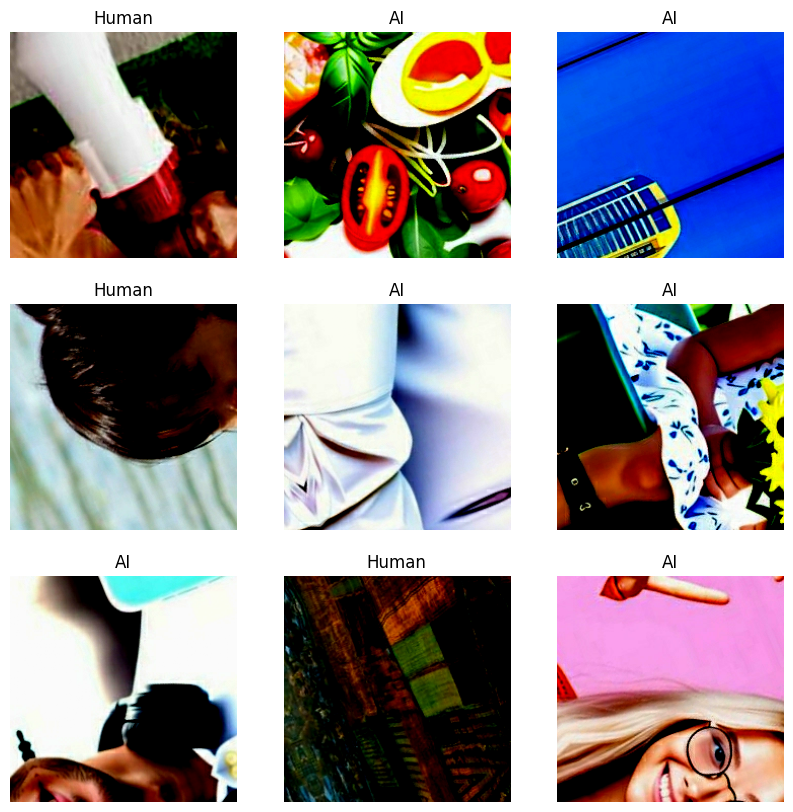

In [4]:
image_batch, label_batch = next(iter(res_train_ds))

print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze layers
base_model.trainable = False

ResNet-50 Model

We use categorical focal loss as a form of hard negative mining to help the model learn to classify harder examples better. We provide the hyperband files [here](https://drive.google.com/drive/folders/12kS5QrlfFyQLGImSDkKRjteh5mwp1KXy?usp=sharing)

In [15]:
# ResNet-50 Model
def build_resnet50(hparams):

    # Add custom layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    
    units = hparams.Int('units', min_value=128, max_value=256, step=64)
    
    x = layers.Dense(units, activation='relu')(x)
    
    dropout_rate = hparams.Float('dropout_rate', 0.2, 0.4, step=0.1)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x) 
    
    model = models.Model(inputs, outputs)
    
    
    learning_rate = hparams.Float('learning_rate', 1e-4, 1e-3, sampling='log')
    momentum = hparams.Float('momentum', 0.9, 0.99, sampling='log')
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, clipvalue=1.0)  # Gradient Clipping
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalFocalCrossentropy(), 
        metrics=[keras.metrics.AUC(),
                keras.metrics.F1Score("weighted", threshold=0.5),]
    )

    return model

# Define the Hyperband tuner
tuner = kt.Hyperband(
    build_resnet50,
    objective=kt.Objective("val_f1_score", direction="max"),  
    max_epochs=EPOCHS,
    factor=6,  
    directory="hyperband_tuning",
    project_name="resnet_tuning_v32131289_blur_nomix_focal"
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=3)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/resnet_tuning_v32131289_blur_nomix_focal")

# Run the hyperparameter search
tuner.search(
    res_train_ds,
    validation_data=res_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=1999,
    callbacks=[early_stopping, tensorboard_callback]
)




Reloading Tuner from hyperband_tuning/resnet_tuning_v32131289_blur_nomix_focal/tuner0.json


In [16]:
best_hparams = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print("Num units:", best_hparams.get("units"))
print("Dropout:", best_hparams.get("dropout_rate"))
print("Learning rate:", best_hparams.get("learning_rate"))
print("Momentum:", best_hparams.get("momentum"))

Best hyperparameters:
Num units: 256
Dropout: 0.4
Learning rate: 0.0005522688258090452
Momentum: 0.9879773848622331


## Visualizing Hyperband 

We can also see how hyperband explores the hyperparameter space and culls poor performing parameters and allocates more resources to better performing ones 
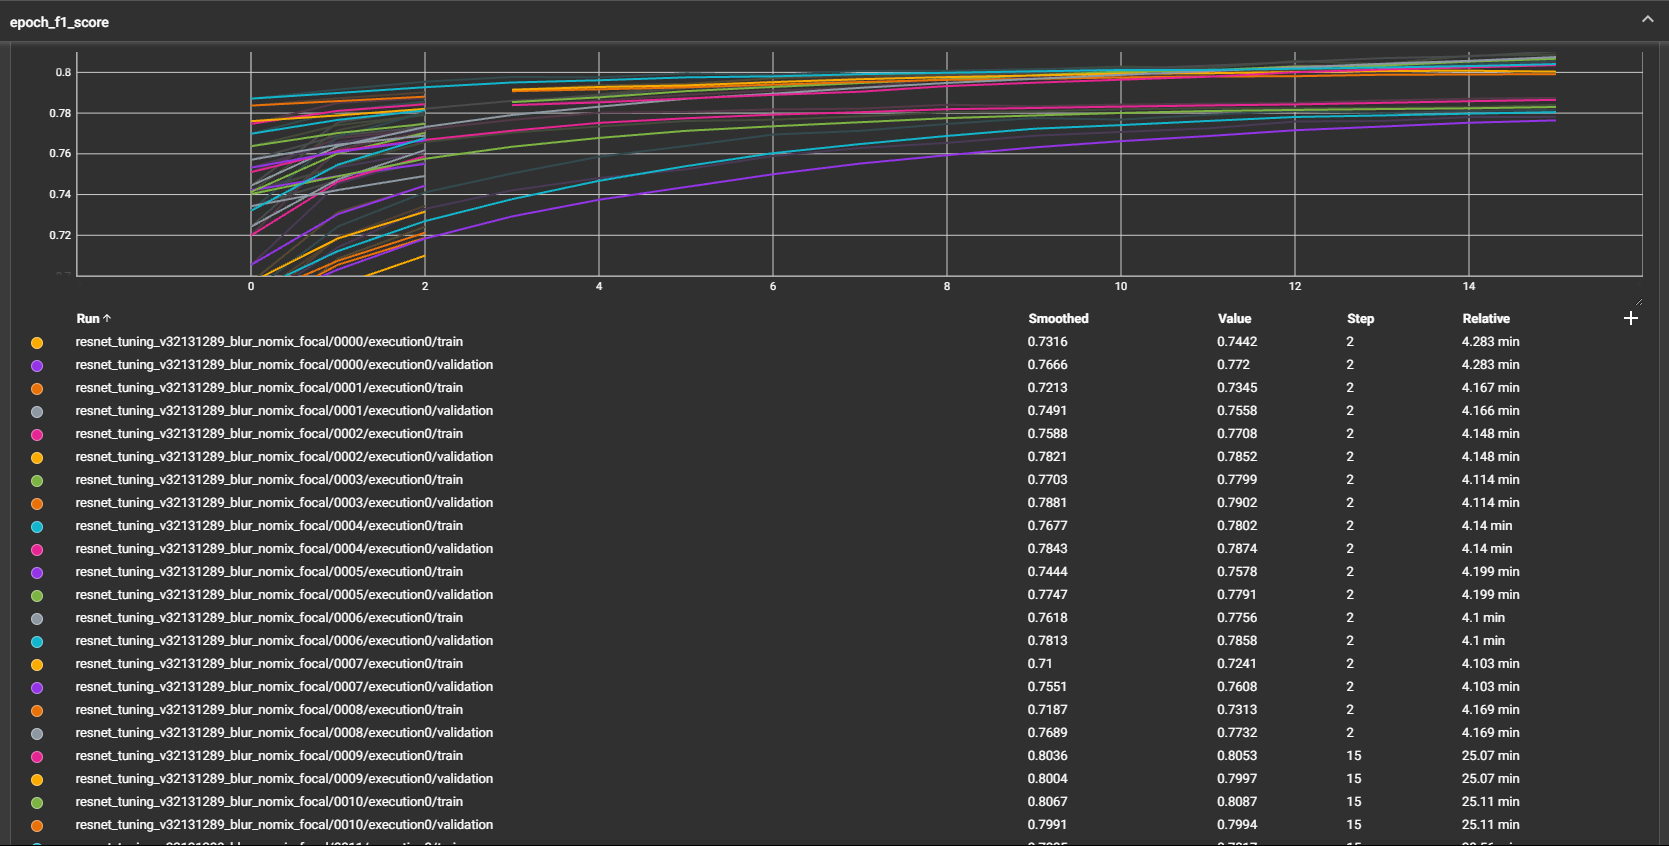

## Fit the best Model with max epochs 

In [17]:
EPOCHS = 32
BATCH_SIZE = 32

In [22]:

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=3, min_delta=0.01, mode="max")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/resnet_tuned_best_v32131289_blur_nomix_focal")
save_model = keras.callbacks.ModelCheckpoint("models/resnet_tuned_best_v32131289_blur_nomix_focal.keras", save_best_only=True, mode="max", monitor="val_f1_score")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(
    res_train_ds,
    validation_data=res_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=1999,
    callbacks=[early_stopping, tensorboard_callback, save_model]
)

Epoch 1/32
1998/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc_2: 0.7821 - f1_score: 0.7177 - loss: 0.0477

2025-03-30 23:08:53.613950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc_2: 0.7821 - f1_score: 0.7177 - loss: 0.0477

/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 139s 67ms/step - auc_2: 0.7821 - f1_score: 0.7178 - loss: 0.0477 - val_auc_2: 0.8649 - val_f1_score: 0.7829 - val_loss: 0.0299
Epoch 2/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc_2: 0.8555 - f1_score: 0.7758 - loss: 0.0305

2025-03-30 23:11:06.057384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 126s 63ms/step - auc_2: 0.8555 - f1_score: 0.7758 - loss: 0.0305 - val_auc_2: 0.8700 - val_f1_score: 0.7892 - val_loss: 0.0294
Epoch 3/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc_2: 0.8615 - f1_score: 0.7801 - loss: 0.0299

2025-03-30 23:13:12.153119: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-03-30 23:13:35.914438: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-30 23:13:35.914487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6693875850195365328
2025-03-30 23:13:35.914541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13511658496631827750


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 129s 65ms/step - auc_2: 0.8615 - f1_score: 0.7801 - loss: 0.0299 - val_auc_2: 0.8729 - val_f1_score: 0.7900 - val_loss: 0.0291
Epoch 4/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc_2: 0.8675 - f1_score: 0.7863 - loss: 0.0294

2025-03-30 23:15:19.823747: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 124s 62ms/step - auc_2: 0.8675 - f1_score: 0.7863 - loss: 0.0294 - val_auc_2: 0.8747 - val_f1_score: 0.7946 - val_loss: 0.0290
Epoch 5/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc_2: 0.8705 - f1_score: 0.7882 - loss: 0.0291

2025-03-30 23:17:27.880591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 128s 64ms/step - auc_2: 0.8705 - f1_score: 0.7882 - loss: 0.0291 - val_auc_2: 0.8766 - val_f1_score: 0.7945 - val_loss: 0.0289
Epoch 6/32
   2/1999 ━━━━━━━━━━━━━━━━━━━━ 1:42 51ms/step - auc_2: 0.8591 - f1_score: 0.8000 - loss: 0.0293

2025-03-30 23:17:49.422287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6693875850195365328
2025-03-30 23:17:49.422352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13511658496631827750


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc_2: 0.8739 - f1_score: 0.7925 - loss: 0.0288

2025-03-30 23:19:36.743837: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-03-30 23:19:58.781356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6693875850195365328
2025-03-30 23:19:58.781433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13511658496631827750


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 130s 65ms/step - auc_2: 0.8739 - f1_score: 0.7925 - loss: 0.0288 - val_auc_2: 0.8774 - val_f1_score: 0.7973 - val_loss: 0.0288
Epoch 7/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc_2: 0.8773 - f1_score: 0.7948 - loss: 0.0284

2025-03-30 23:21:43.042835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 125s 62ms/step - auc_2: 0.8773 - f1_score: 0.7948 - loss: 0.0284 - val_auc_2: 0.8759 - val_f1_score: 0.7963 - val_loss: 0.0293


We can see below when run with more epochs that the validation score actually starts to plateau but training score still increases indicating overfitting to the training data
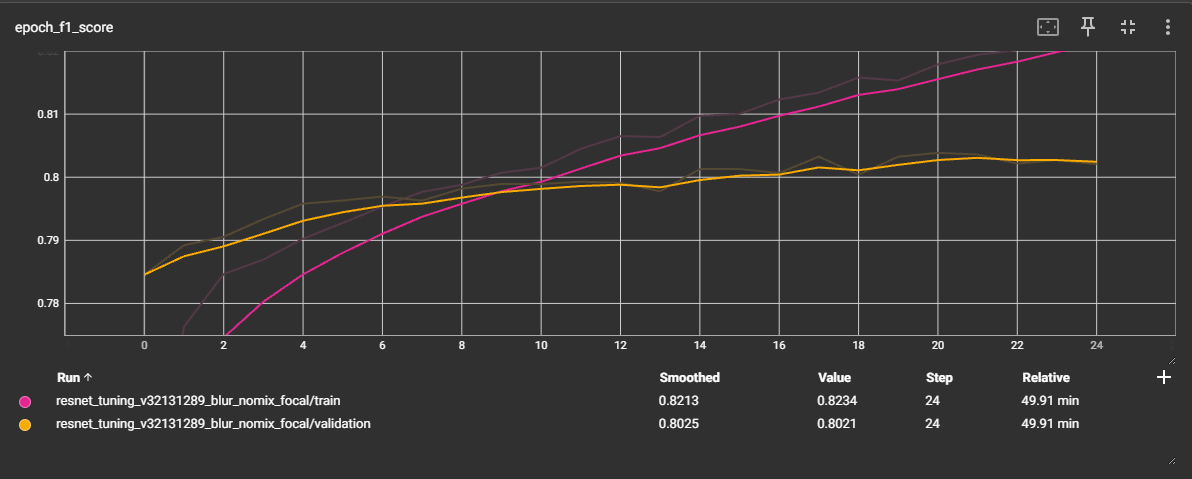

We do not fine tune the convolutional layers to improve generalization and to prevent overfitting to the limited features present in the training set compared to the diverse testing set

## Load and evaluate the model from .keras file and the test data
We first load the model and the test data and then use the model to predict the class of the test pictures

We provide the pretrained models [here](https://drive.google.com/drive/folders/11owFyKsbaYWEidl0p7U7SN3okqqtopnH?usp=sharing)

In [23]:

model = keras.saving.load_model("models/resnet_tuned_best_v32131289_blur_nomix_focal.keras")

test_ds = load_test_tfrecord("records/resnet_test.tfrecord", BATCH_SIZE, "resnet")

predictions = model.predict(test_ds)


174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step


We now save the predictions to a CSV file for submission to Kaggle

In [24]:
predicted_classes = tf.argmax(predictions, axis=1, output_type=tf.int32)
test_df = pd.read_csv("archive/test.csv")
ids = test_df["id"].values

# Convert predictions to strings for CSV outputs
predictions_str = tf.strings.as_string(predicted_classes)

# Create CSV content
csv_header = "id,label\n"
csv_rows = tf.strings.join([tf.strings.as_string(ids), predictions_str], separator=",")
csv_content = tf.strings.join([csv_header, tf.strings.reduce_join(csv_rows, separator="\n")])

# Save the CSV file
tf.io.write_file("resnet_submission.csv", csv_content)

print("Submission saved as resnet_submission.csv")

Submission saved as resnet_submission.csv


## Saving predictions for ensemble training

In [25]:
# Convert predictions to strings for CSV output
predictions_str = tf.strings.as_string(predictions)

predictions_flat = tf.strings.reduce_join(predictions_str, axis=1, separator=",")
# Create CSV content
csv_header = "id,label1,label2\n"
csv_rows = tf.strings.join([tf.strings.as_string(ids), predictions_flat], separator=",")
csv_content = tf.strings.join([csv_header, tf.strings.reduce_join(csv_rows, separator="\n")])

# Save the CSV file
tf.io.write_file("resnet_predictions.csv", csv_content)

print("Predictions saved as resnet_predictions.csv")

Predictions saved as resnet_predictions.csv
